In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt

In [2]:
import random 
import os
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
import time 
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [3]:
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


In [4]:
Base_path = '../data/m5-forecasting-accuracy/'

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [44]:

print(Base_path + 'sells_data_6780_5289.csv')
y= pd.read_csv(Base_path + 'sells_data_6780_5289.csv')

../data/m5-forecasting-accuracy/sells_data_6780_5289.csv


In [45]:
calendar_df = pd.read_csv(Base_path + 'calendar.csv')
calendar_df = reduce_mem_usage(calendar_df)
print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))
print(calendar_df.head())
date_index = calendar_df['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
         date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  


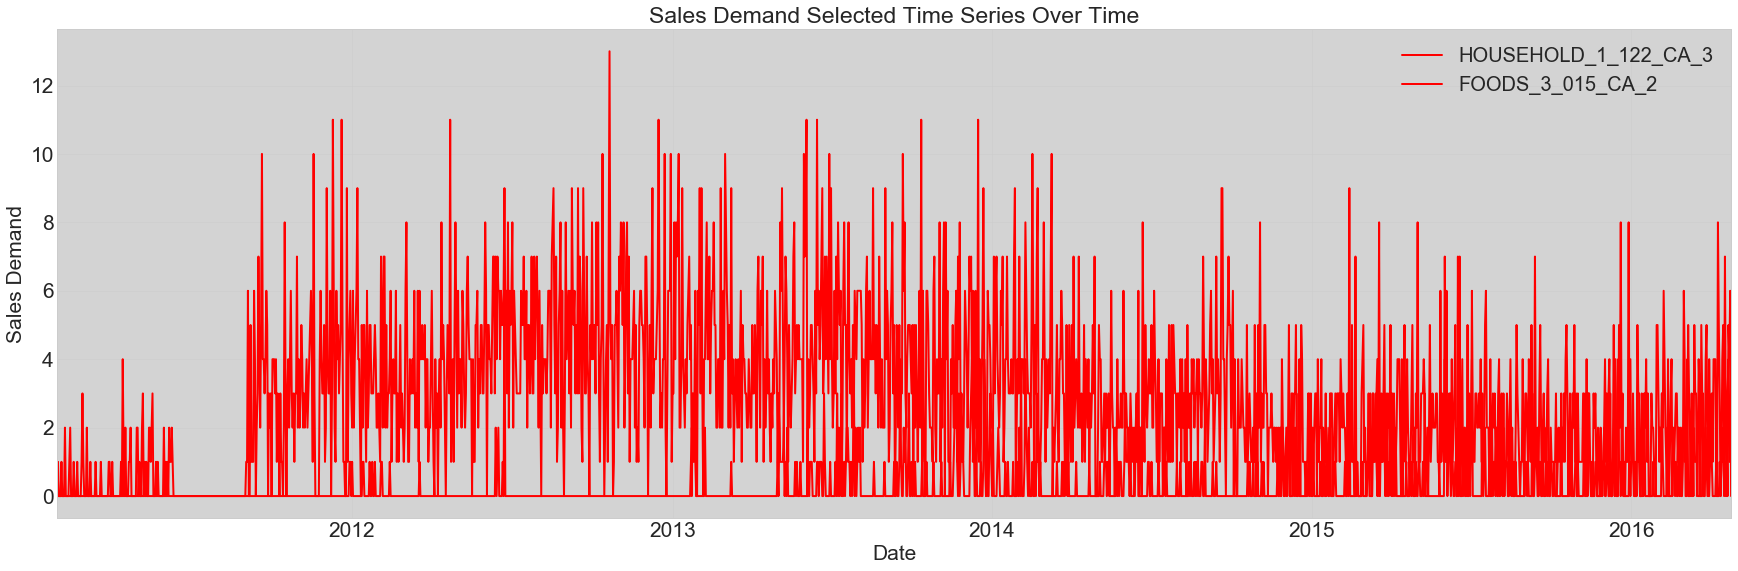

17669

In [46]:
#Select arbitrary index and plot the time series
#index = 6780

y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 

y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='red')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()
#del calendar_df, sales_train_validation_df,DF_Sales
gc.collect()

In [47]:
print(y.iloc[:,:1].head())

            HOUSEHOLD_1_122_CA_3
2011-01-29                     0
2011-01-30                     0
2011-01-31                     0
2011-02-01                     0
2011-02-02                     0


In [48]:
SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

### Normalize Data


In [49]:
data = np.array(y.iloc[:,1])
print(data.shape)
scaler = MinMaxScaler(feature_range=(-1, 1))
print(data.reshape(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))
print(train_data_normalized.shape)

(1913,)
[[0]
 [1]
 [0]
 ...
 [4]
 [6]
 [0]]
(1913, 1)


We create a sliding window which builds sequences and labels. In our case, we have sequences of 28 days, that will use to predict the next day.

In [50]:
###  This function creates a sliding window or sequences of 28 days and one day label ####
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)
#train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
seq_length = 28
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)


(1884, 28, 1)
(1884, 1)


In [51]:
from sklearn.model_selection import train_test_split
from numpy import savetxt

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

print('X : {}'.format(x.shape))
print('Y : {}'.format(y.shape))

X_train_o = np.array(x[0:train_size])
y_train_o = np.array(y[0:train_size])

X_test_o =  np.array(x[train_size:])
y_test_o =  np.array(y[train_size:])
print('X_train : {}'.format(X_train_o.shape))
print('Y_train : {}'.format(y_train_o.shape))
print('X_test : {}'.format(X_test_o.shape))
print('Y_test : {}'.format(y_test_o.shape))
#X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.33, random_state=42)



X : (1884, 28, 1)
Y : (1884, 1)
X_train : (1262, 28, 1)
Y_train : (1262, 1)
X_test : (622, 28, 1)
Y_test : (622, 1)


In [52]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings('ignore')

def lstm_model_init():
    # Initialising the RNN
    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    layer_1_units=50
    regressor.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (28,1)))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    layer_2_units=400
    regressor.add(LSTM(units = layer_2_units, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    layer_3_units=400
    regressor.add(LSTM(units = layer_3_units))
    regressor.add(Dropout(0.2))

    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

In [53]:
# train and test data set

train_dataset  = X_train_o
test_dataset = X_test_o
train_y = y_train_o
test_y = y_test_o

# mean and var data set
mean_var_size = int(len(train_y) * 0.50)

mean_x_dataset = np.array(train_dataset[0:mean_var_size])
mean_labels = np.array(train_y[0:mean_var_size])

var_x_dataset = np.array(train_dataset[mean_var_size:])
var_labels = np.array(train_y[mean_var_size:])

print(mean_x_dataset.shape)
print(var_x_dataset.shape)
print(train_dataset.shape)

(631, 28, 1)
(631, 28, 1)
(1262, 28, 1)


Here is again an important part.
We are using last 14 days in order to predict day 1915 sales.
In order to predict 1916th day, 13 days from our input data and 1 day from our prediction are used. After that we slide the window one by one.
12 days from input data + 2 days from our prediction to predict 1917th day
11 days from input data + 3 days from our prediction to predict 1918th day
.....
14 days our prediction to predict last 1941th day sales.

In [54]:
normed_mean_data = mean_x_dataset
normed_var_data = var_x_dataset
normed_test_data = test_dataset

In [55]:
# train the models
# Fitting the RNN to the Training set
epoch_no=32
batch_size_RNN=44

mean_model = lstm_model_init()
mean_model.fit(normed_mean_data, mean_labels, epochs = epoch_no, batch_size = batch_size_RNN)
mean_predictions = mean_model.predict(normed_var_data)


var_model = lstm_model_init()
squared_residuals = (var_labels.reshape(-1,1) - mean_predictions) ** 2
# print(squared_residuals)
var_model.fit(normed_var_data, squared_residuals, epochs = epoch_no, batch_size = batch_size_RNN)





Epoch 1/32
631/631 [==============================] - 11s 17ms/step - loss: 0.3055
Epoch 2/32
631/631 [==============================] - 8s 13ms/step - loss: 0.0324
Epoch 3/32
631/631 [==============================] - 8s 12ms/step - loss: 0.0155
Epoch 4/32
631/631 [==============================] - 7s 11ms/step - loss: 0.0136
Epoch 5/32
631/631 [==============================] - 8s 13ms/step - loss: 0.0128
Epoch 6/32
631/631 [==============================] - 7s 11ms/step - loss: 0.0140
Epoch 7/32
631/631 [==============================] - 7s 11ms/step - loss: 0.0137
Epoch 8/32
631/631 [==============================] - 7s 11ms/step - loss: 0.0135
Epoch 9/32
631/631 [==============================] - 7s 11ms/step - loss: 0.0132
Epoch 10/32
631/631 [==============================] - 7s 11ms/step - loss: 0.0142
Epoch 11/32
631/631 [==============================] - 7s 11ms/step - loss: 0.0127
Epoch 12/32
631/631 [==============================] - 7s 12ms/step - loss: 0.0128
Epoch 13/32


In [109]:
normed_test_data_p28 = normed_test_data[-29:-1,:,:]
test_y_p28 = test_y[-29:-1]

print(normed_test_data_p28.shape)
print(test_y_p28.shape)
print(test_y_p28)

(28, 28, 1)
(28, 1)
[[-0.55555556]
 [-0.77777778]
 [-1.        ]
 [-0.55555556]
 [-1.        ]
 [-0.77777778]
 [-0.55555556]
 [-0.77777778]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-0.77777778]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-0.77777778]
 [-1.        ]
 [-0.77777778]
 [-0.77777778]
 [-0.55555556]
 [-1.        ]
 [-0.77777778]
 [-1.        ]
 [-0.55555556]
 [-1.        ]
 [ 0.11111111]
 [-0.11111111]]


(2, 28, 1)
[-0.5555555555555556, -0.7777777777777778, -1.0, -0.5555555555555556, -1.0, -0.7777777777777778, -0.5555555555555556, -0.7777777777777778, -1.0, -1.0, -1.0, -1.0, -0.7777777777777778, -1.0, -1.0, -1.0, -0.7777777777777778, -1.0, -0.7777777777777778, -0.7777777777777778, -0.5555555555555556, -1.0, -0.7777777777777778, -1.0, -0.5555555555555556, -1.0, 0.11111111111111116, -0.11111111111111116]
[0.0567636638879776, 0.05972946435213089, 0.0618882030248642, 0.05984515696763992, 0.06133776158094406, 0.05943746119737625, 0.05821691453456879, 0.060839153826236725, 0.06235118955373764, 0.059552960097789764, 0.05476146191358566, 0.0501912459731102, 0.04693371802568436, 0.04798433929681778, 0.0485989972949028, 0.048427313566207886, 0.0479387491941452, 0.050338469445705414, 0.05132201313972473, 0.05377834290266037, 0.056827910244464874, 0.062323056161403656, 0.06242245435714722, 0.06166980415582657, 0.0582273006439209, 0.05953960120677948, 0.05807569622993469, 0.06896814703941345]


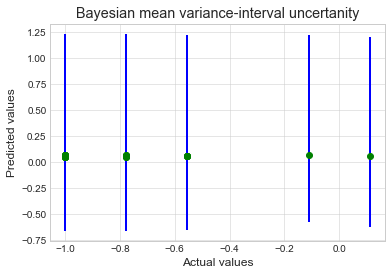

In [110]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#normed_test_data = normed_test_data.dropna()

mean_predictions = mean_model.predict(normed_test_data_p28)
var_predictions = var_model.predict(normed_test_data_p28)

var_predictions[var_predictions < 0] = 0
ci= 0.95
lower_bound = mean_predictions - ci*np.sqrt(var_predictions)
upper_bound = mean_predictions + ci*np.sqrt(var_predictions)

error_variance = np.array([lower_bound, upper_bound])
print(error_variance.shape)
error_variance = error_variance.reshape(2,28)

x1 = normed_test_data_p28
y_pred_bv = var_model.predict(x1)
y_actual_bv = test_y_p28.T

#print(error_variance.shape)
print(y_actual_bv.tolist()[0])
#print(y_actual_bv.reshape(1,-1))
print(y_pred_bv.reshape(1, -1).tolist()[0])
#print(y_pred_bv.shape)
plt.errorbar( y_actual_bv.tolist()[0], y_pred_bv.reshape(1, -1).tolist()[0], yerr=error_variance, fmt='o', color='green',
             ecolor='blue', elinewidth=2, capsize=0 )
plt.title('Bayesian mean variance-interval uncertanity')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()
#plt.figsize=(12, 10)



In [120]:
print(test_y_p28.T[0])
print(upper_bound.reshape(1,-1)[0] )
print(lower_bound.reshape(1,-1)[0])
print(picp(test_y_p28.T[0], upper_bound.reshape(1,-1)[0] , lower_bound.reshape(1,-1)[0]))
print(mpiw( upper_bound.reshape(1,-1)[0] , lower_bound.reshape(1,-1)[0]))

[-0.55555556 -0.77777778 -1.         -0.55555556 -1.         -0.77777778
 -0.55555556 -0.77777778 -1.         -1.         -1.         -1.
 -0.77777778 -1.         -1.         -1.         -0.77777778 -1.
 -0.77777778 -0.77777778 -0.55555556 -1.         -0.77777778 -1.
 -0.55555556 -1.          0.11111111 -0.11111111]
[-0.68463606 -0.677701   -0.67123896 -0.67428917 -0.66804504 -0.6696034
 -0.67048854 -0.66065013 -0.65362585 -0.6562344  -0.66651314 -0.67989075
 -0.6937431  -0.696677   -0.7010183  -0.7083209  -0.71642196 -0.7161525
 -0.7185399  -0.7159928  -0.7092978  -0.6936281  -0.68899274 -0.68583274
 -0.69009113 -0.68291724 -0.6836432  -0.65046066]
[-1.1373135 -1.1420536 -1.1439084 -1.1390913 -1.1386077 -1.1328197
 -1.128924  -1.1292964 -1.12806   -1.1199003 -1.1111352 -1.1055554
 -1.1053628 -1.1128783 -1.1198766 -1.1264389 -1.1324254 -1.142441
 -1.1489727 -1.1566058 -1.1622313 -1.1679552 -1.163698  -1.1576674
 -1.1485674 -1.1465312 -1.1415223 -1.1494346]
0.75
0.45195099285670687


In [ ]:
import seaborn as sns
for feat in features:
    if feat in ['Popularity','Year']:
        continue
    fig = sns.catplot(x="Year", y=feat, hue="Success", kind="box", data=x_04_19, height=4, aspect=2)
    label = feat+'-vs-Year'
    fig.set(title=label)
    fig.savefig('../images/'+label+'.png')

In [106]:
import keras.backend as K
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

model = lstm_model_init()
model.compile(loss=lambda y,f: tilted_loss(0.5,y,f), optimizer='adam')

lowerq_model = lstm_model_init()
lowerq_model.compile(loss=lambda y,f: tilted_loss(0.025,y,f), optimizer='adam')

upperq_model = lstm_model_init()
upperq_model.compile(loss=lambda y,f: tilted_loss(0.9725,y,f), optimizer='adam')

In [107]:

normed_train_data_q = X_train_o
train_labels_q = y_train_o

epoch_no=32
batch_size_RNN=44


model.fit(normed_train_data_q, train_labels_q, epochs = epoch_no, batch_size = batch_size_RNN)
lowerq_model.fit(normed_train_data_q, train_labels_q, epochs = epoch_no, batch_size = batch_size_RNN)
upperq_model.fit(normed_train_data_q, train_labels_q, epochs = epoch_no, batch_size = batch_size_RNN)

pred = model.predict(normed_test_data_p28)
l_pred = lowerq_model.predict(normed_test_data_p28)
u_pred = upperq_model.predict(normed_test_data_p28)


Epoch 1/32
1262/1262 [==============================] - 18s 14ms/step - loss: 0.1043
Epoch 2/32
1262/1262 [==============================] - 16s 13ms/step - loss: 0.0476
Epoch 3/32
1262/1262 [==============================] - 15s 11ms/step - loss: 0.0503
Epoch 4/32
1262/1262 [==============================] - 15s 12ms/step - loss: 0.0439
Epoch 5/32
1262/1262 [==============================] - 14s 11ms/step - loss: 0.0446
Epoch 6/32
1262/1262 [==============================] - 14s 11ms/step - loss: 0.0415
Epoch 7/32
1262/1262 [==============================] - 14s 11ms/step - loss: 0.0415
Epoch 8/32
1262/1262 [==============================] - 14s 11ms/step - loss: 0.0450
Epoch 9/32
1262/1262 [==============================] - 14s 11ms/step - loss: 0.0421
Epoch 10/32
1262/1262 [==============================] - 15s 12ms/step - loss: 0.0418
Epoch 11/32
1262/1262 [==============================] - 14s 11ms/step - loss: 0.0395
Epoch 12/32
1262/1262 [==============================] - 14s 11

1262/1262 [==============================] - 14s 11ms/step - loss: 0.0169


(1, 28)
(2, 1, 28)
(2, 28)
(28, 1)
(28, 1)


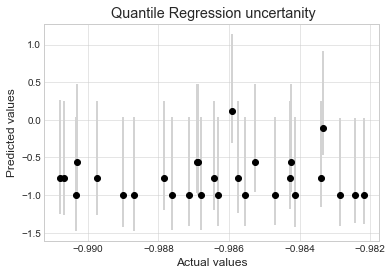

In [108]:

print(l_pred.T.shape)
error_variance = np.array([l_pred.T, u_pred.T])
print(error_variance.shape)
error_variance = error_variance.reshape(2,28)
print(error_variance.shape)

y_pred = pred
y_actual = test_y_p28
print(y_pred.shape)
print(y_actual.shape)
plt.errorbar( y_pred, y_actual, yerr=error_variance, fmt='o', color='black',
             ecolor='lightgray', elinewidth=2, capsize=0 )
plt.title(' Quantile Regression uncertanity')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()
#plt.figsize=(12, 10)



In [121]:
def picp(actual, upper_b , lower_b):
    picp = 0
    for (a, u, l) in zip(actual, upper_b , lower_b): 
        if l < a < u:
            picp += 1 
    return picp/len(actual)

def mpiw( upper_b , lower_b ):
    return np.sum(np.absolute(upper_b.T - lower_b.T))/len(upper_b)

print('For quantiles')
picp_val = picp(y_actual, u_pred ,l_pred)
print(picp_val)
mpiw_val = mpiw( u_pred ,l_pred)
print(mpiw_val)
print('For MLE')


For quantiles
0.9285714285714286
0.6040262494768415
For MLE
